In [ ]:
# Install packages #
# !pip install numpy
# !pip install matplotlib
# !pip install torch
# !pip install xlrd
# !pip install pandas
# !pip install torchvision

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch import Tensor
from torch.optim.optimizer import (Optimizer, required, _use_grad_for_differentiable, _default_to_fused_or_foreach,
                        _differentiable_doc, _foreach_doc, _maximize_doc)
from typing import List, Optional

In [ ]:
# Loading training data
#dataset = pd.read_csv("bmi_train.csv")
#dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
#dataset = dataset.to_numpy()

# Splitting off 80% of data for training, 20% for validation
#train_split = int(0.8 * len(dataset))
#X_train = dataset[:train_split, [0,1,2]]
#y_train = dataset[:train_split, 3]
#X_test = dataset[train_split:, [0,1,2]]
#y_test = dataset[train_split:, 3]

#print(X_train)
#print(y_train)

# Loading prediction data
#prediction_dataset = pd.read_csv("bmi_validation.csv")
#prediction_dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
#X_prediction = prediction_dataset.to_numpy()

# Normalize data set
#X_train_normalized = (X_train - X_train.min(0)) / (X_train.max(0) - X_train.min(0))
#X_test_normalized = (X_test - X_test.min(0)) / (X_test.max(0) - X_test.min(0))
#X_prediction_normalized = (X_prediction - X_prediction.min(0)) / (X_prediction.max(0) - X_prediction.min(0))

# Turn data to tensor
#X_train_tensor = torch.from_numpy(X_train_normalized)
#y_train_tensor = torch.from_numpy(y_train)
#X_test_tensor = torch.from_numpy(X_test_normalized)
#y_test_tensor = torch.from_numpy(y_test)
#X_prediction_tensor = torch.from_numpy(X_prediction_normalized)

In [2]:
# Loading training data
dataset = pd.read_csv("epsilon_normalized", sep=' ', header=None, nrows=1000)
dataset = dataset.to_numpy()
for i in range(1, dataset.shape[1]-1):
    dataset[:, i] = [float(value.split(':')[1]) if isinstance(value, str) else value for value in dataset[:, i]]
dataset = dataset[:, :-1]
print(dataset)


# Splitting off data for training and validation
train_split = int(0.8 * len(dataset))
X_train = dataset[:train_split, 1:].astype(np.float32)
y_train = dataset[:train_split, 0].astype(np.float32)
X_test = dataset[train_split:, 1:].astype(np.float32)
y_test = dataset[train_split:, 0].astype(np.float32)
#print(X_train)
#print(y_train)

# Normalize data set
X_train_normalized = (X_train - X_train.min(0)) / (X_train.max(0) - X_train.min(0))
X_test_normalized = (X_test - X_test.min(0)) / (X_test.max(0) - X_test.min(0))

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train_normalized)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_normalized)
y_test_tensor = torch.from_numpy(y_test)
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

[[1 -0.0108282 -0.0196004 ... -0.0107833 -0.00341473 -0.0131107]
 [-1 -0.00470349 0.0169135 ... -0.0430199 -0.032248 -0.00424447]
 [1 0.00250835 0.0168447 ... -0.038255 -0.031005 -0.0168385]
 ...
 [-1 0.0103883 -0.0310115 ... 0.00536232 -0.00887889 -0.0570236]
 [1 0.00903997 0.0155853 ... -0.0331243 -0.0315165 -0.0139837]
 [-1 -0.0113611 0.0237702 ... -0.0371067 -0.0203854 -0.00976943]]
torch.Size([800, 1999])
torch.Size([800])
torch.Size([200, 1999])
torch.Size([200])


In [3]:
# Train and test error rate analysis function
def calculate_error_rate(X, y, w, b):
    num_samples = X.shape[0]
    y_pred = np.dot(X, w) + b
    y_pred = torch.round(torch.from_numpy(y_pred))
    error_count = torch.count_nonzero(y_pred - y)
    error_rate = error_count / num_samples
    return error_rate

Custom SGD

tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [1/1000], Loss: 1.00000000
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [10/1000], Loss: 0.99674284
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [20/1000], Loss: 0.99402458
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [30/1000], Loss: 0.99175298
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [40/1000], Loss: 0.98974782
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [50/1000], Loss: 0.98790249
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [60/1000], Loss: 0.98615391
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [70/1000], Loss: 0.98446477
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [80/1000], Loss: 0.98281297
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [90/1000], Loss: 0.98118543
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [100/1000], Loss: 0.97957440
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [110/1000], Loss: 0.97797528
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [120/1000], Loss: 0.976385

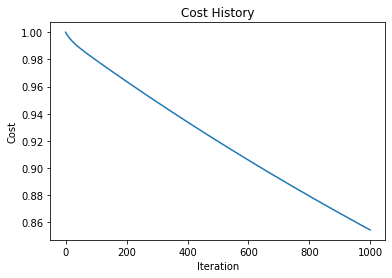

Train error rate: tensor(1.)
Test error rate: tensor(1.)


In [23]:
# Vanilia Gradient Descent Algorithms
def gradient_descent(X, y, learning_rate, num_iterations):
    num_samples, num_features = X.shape
    
    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    cost_history = []
    
    for epoch in range(num_iterations):
        # Calculate predictions
        y_pred = np.dot(X, w) + b
        
        # Calculate the difference between predictions and actual values
        error = y_pred - y
        
        # Calculate the gradient
        w_gradient = (1/num_samples) * np.dot(X.T, error)
        b_gradient = (1/num_samples) * np.sum(error)
        
        # Update theta using the learning rate and gradient
        w -= learning_rate * w_gradient
        b -= learning_rate * b_gradient
        
        # Calculate the cost (mean squared error)
        cost = np.mean(np.square(error))
        cost_history.append(cost)

        # Print the loss every 100 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(outputs[1])
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.8f}')
    
    return w, b, cost_history

# Train the model using gradient descent
learning_rate = 0.001
num_iterations = 1000
w, b, cost_history = gradient_descent(X_train_normalized, y_train, learning_rate, num_iterations)

# Print the learned parameters
print("Learned parameters:")

for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w, b)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w, b)
    print("Test error rate:", test_error_rate)

tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [1/1000], Loss: 0.98926044
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [10/1000], Loss: 1.01788754
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [20/1000], Loss: 0.75582290
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [30/1000], Loss: 0.58245199
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [40/1000], Loss: 0.66656723
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [50/1000], Loss: 0.61351736
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [60/1000], Loss: 0.56317425
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [70/1000], Loss: 0.52916954
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [80/1000], Loss: 0.51444386
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [90/1000], Loss: 0.30596217
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [100/1000], Loss: 0.37333298
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [110/1000], Loss: 0.39078441
tensor(-0.0745, grad_fn=<SelectBackward0>)
Epoch [120/1000], Loss: 0.540510

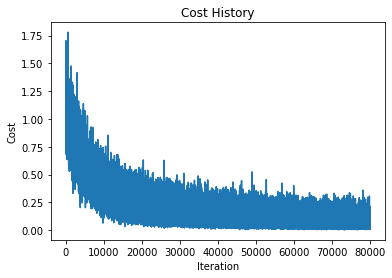

Train error rate: tensor(0.0988)
Test error rate: tensor(0.6050)


In [22]:
# Stochastic Gradien Descent Algorithms
def stochastic_gradient_descent(X, y, learning_rate, num_epochs, batch_size):
    num_samples, num_features = X.shape
    num_batches = num_samples // batch_size

    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    cost_history = []

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for batch in range(num_batches):
            # Select the current batch
            start = batch * batch_size
            end = (batch + 1) * batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Calculate predictions
            y_pred = np.dot(X_batch, w) + b

            # Calculate the difference between predictions and actual values
            error = y_pred - y_batch

            # Calculate the gradients
            w_gradient = (1 / batch_size) * np.dot(X_batch.T, error)
            b_gradient = (1 / batch_size) * np.sum(error)

            # Update weights and bias
            w -= learning_rate * w_gradient
            b -= learning_rate * b_gradient

            # Calculate the cost (mean squared error)
            cost = np.mean(np.square(error))
            cost_history.append(cost)

        # Print the loss every 100 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(outputs[1])
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.8f}')
            
    return w, b, cost_history

# Train the model using stochastic gradient descent
learning_rate = 0.001
num_epochs = 1000
batch_size = 10
w, b, cost_history = stochastic_gradient_descent(X_train_normalized, y_train, learning_rate, num_epochs, batch_size)

# Print the learned parameters
print("Learned parameters:")
for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w, b)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w, b)
    print("Test error rate:", test_error_rate)

Pytorch SGD

Pytorch SGD Test (This is done by Chris for testing purpose)

Epoch [1/20000], Loss: 1.00000000
Epoch [10/20000], Loss: 0.99425143
Epoch [20/20000], Loss: 0.98992383
Epoch [30/20000], Loss: 0.98631668
Epoch [40/20000], Loss: 0.98297197
Epoch [50/20000], Loss: 0.97973198
Epoch [60/20000], Loss: 0.97654170
Epoch [70/20000], Loss: 0.97338241
Epoch [80/20000], Loss: 0.97024721
Epoch [90/20000], Loss: 0.96713364
Epoch [100/20000], Loss: 0.96404076
Epoch [110/20000], Loss: 0.96096802
Epoch [120/20000], Loss: 0.95791489
Epoch [130/20000], Loss: 0.95488143
Epoch [140/20000], Loss: 0.95186746
Epoch [150/20000], Loss: 0.94887245
Epoch [160/20000], Loss: 0.94589633
Epoch [170/20000], Loss: 0.94293869
Epoch [180/20000], Loss: 0.93999964
Epoch [190/20000], Loss: 0.93707895
Epoch [200/20000], Loss: 0.93417609
Epoch [210/20000], Loss: 0.93129098
Epoch [220/20000], Loss: 0.92842370
Epoch [230/20000], Loss: 0.92557383
Epoch [240/20000], Loss: 0.92274117
Epoch [250/20000], Loss: 0.91992551
Epoch [260/20000], Loss: 0.91712677
Epoch [270/20000], Loss: 0.91434479
Epo

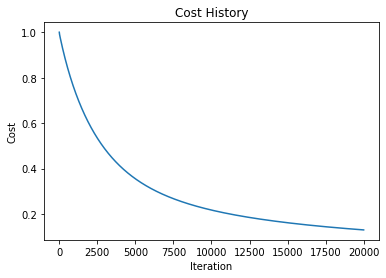

Train error rate: tensor(0.1737)
Test error rate: tensor(0.6150)


In [13]:
# Define the learning rate and number of epochs
learning_rate = 0.001
num_epochs = 30000

# Define the number of features
num_features = X_train_tensor.size()[1]

# Define the model parameters (weights and bias)
w = torch.zeros(num_features, dtype=torch.float, requires_grad=True)
# w = torch.tensor([1., 1., 1.], requires_grad=True)
b = torch.zeros(1, dtype=torch.float, requires_grad=True)
# b = torch.tensor([1.], requires_grad=True)
cost_history = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer (Vanilla Gradient Descent)
optimizer = torch.optim.SGD([w, b], lr=learning_rate, weight_decay=0)

# Perform gradient descent
for epoch in range(num_epochs):
    # Forward pass
    outputs = torch.matmul(X_train_tensor.float(), w) + b
    loss = criterion(outputs, y_train_tensor.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss
    cost_history.append(loss.detach().numpy())
    
    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
        

# Print learned parameters
print('Trained weights:', w)
print('Trained bias:', b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w.detach().numpy(), b.detach().numpy())
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w.detach().numpy(), b.detach().numpy())
    print("Test error rate:", test_error_rate)

Custom SGD Class

In [14]:
class custom_optimizer_SGD(Optimizer):
    def __init__(self, params, lr=required, weight_decay=0 ):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super().__init__(params, defaults)
                
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad.data
                weight_decay = group['weight_decay']
                lr = group['lr']
                param.data.add_(-lr, grad)
                if weight_decay != 0:
                    param.data.add_(-lr * weight_decay, param.data)

Neural Network

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation_stack): Sequential(
    (0): Linear(in_features=1999, out_features=1, bias=True)
  )
)
tensor(-0.0287, grad_fn=<SelectBackward0>)
Epoch [1/5000], Loss: 1.01643372
tensor(0.0286, grad_fn=<SelectBackward0>)
Epoch [10/5000], Loss: 1.00187731
tensor(0.0054, grad_fn=<SelectBackward0>)
Epoch [20/5000], Loss: 0.99702573
tensor(-0.0083, grad_fn=<SelectBackward0>)
Epoch [30/5000], Loss: 0.99317557
tensor(-0.0166, grad_fn=<SelectBackward0>)
Epoch [40/5000], Loss: 0.98968607
tensor(-0.0217, grad_fn=<SelectBackward0>)
Epoch [50/5000], Loss: 0.98633593
tensor(-0.0248, grad_fn=<SelectBackward0>)
Epoch [60/5000], Loss: 0.98304862
tensor(-0.0268, grad_fn=<SelectBackward0>)
Epoch [70/5000], Loss: 0.97979760
tensor(-0.0282, grad_fn=<SelectBackward0>)
Epoch [80/5000], Loss: 0.97657359
tensor(-0.0292, grad_fn=<SelectBackward0>)
Epoch [90/5000], Loss: 0.97337312
tensor(-0.0300, grad_fn=<SelectBackward0>)
Epoch [100/5000], Loss: 0.97

C:\Users\chris\AppData\Local\Temp\ipykernel_19204\2543760084.py:31: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1519.)
  param.data.add_(-lr, grad)


Epoch [120/5000], Loss: 0.96390271
tensor(-0.0316, grad_fn=<SelectBackward0>)
Epoch [130/5000], Loss: 0.96078813
tensor(-0.0321, grad_fn=<SelectBackward0>)
Epoch [140/5000], Loss: 0.95769423
tensor(-0.0325, grad_fn=<SelectBackward0>)
Epoch [150/5000], Loss: 0.95462054
tensor(-0.0330, grad_fn=<SelectBackward0>)
Epoch [160/5000], Loss: 0.95156705
tensor(-0.0334, grad_fn=<SelectBackward0>)
Epoch [170/5000], Loss: 0.94853348
tensor(-0.0338, grad_fn=<SelectBackward0>)
Epoch [180/5000], Loss: 0.94551951
tensor(-0.0342, grad_fn=<SelectBackward0>)
Epoch [190/5000], Loss: 0.94252497
tensor(-0.0346, grad_fn=<SelectBackward0>)
Epoch [200/5000], Loss: 0.93954962
tensor(-0.0350, grad_fn=<SelectBackward0>)
Epoch [210/5000], Loss: 0.93659329
tensor(-0.0354, grad_fn=<SelectBackward0>)
Epoch [220/5000], Loss: 0.93365586
tensor(-0.0358, grad_fn=<SelectBackward0>)
Epoch [230/5000], Loss: 0.93073678
tensor(-0.0362, grad_fn=<SelectBackward0>)
Epoch [240/5000], Loss: 0.92783600
tensor(-0.0365, grad_fn=<Sele

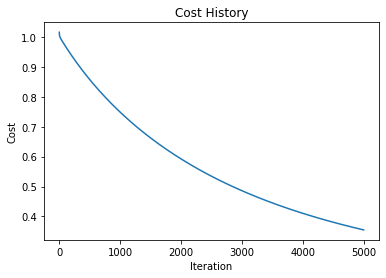

In [20]:
# Define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation_stack = nn.Sequential(
            nn.Linear(1999, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.activation_stack(x)
        return torch.squeeze(logits)
    
# Define the learning rate and number of epochs
learning_rate = 0.001
num_epochs = 5000

# Define the model parameters
cost_history = []

# Define neural network model, loss criterion and optimizer
criterion = torch.nn.MSELoss()
NeuralNetwork_model = NeuralNetwork()
print(NeuralNetwork_model)
optimizer = custom_optimizer_SGD(NeuralNetwork_model.parameters(), lr=learning_rate, weight_decay = 0)

#for name, param in NeuralNetwork_model.named_parameters():
#    print( name )
#    values = torch.ones( param.shape )
#    param.data = values
    
# Perform training
NeuralNetwork_model.train()
for epoch in range(num_epochs):
    # Forward propagation to obtain the predicted output
    outputs = NeuralNetwork_model(X_train_tensor.float())
    
    # Calculate the loss
    loss = criterion(outputs, y_train_tensor.float())
    
    # Backward propagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record the loss
    cost_history.append(loss.item())
    
    # Print the loss every 100 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(outputs[1])
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
        
# Print learned parameters
for name, param in NeuralNetwork_model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data}')
        
        
# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
# train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w.T.detach().numpy(), b.detach().numpy())
# print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
# if X_test is not None and y_test is not None:
#    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w.T.detach().numpy(), b.detach().numpy())
#    print("Test error rate:", test_error_rate)

Fedearted Learning Algorithm

In [ ]:
# Define a custom class for each client so they can update separately
class ClientUpdate:
    def __init__(self, model, criterion, optimizer, train_data_loader):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader

    def update_weights(self, num_epochs):
        self.model.train()
        for epoch in range(num_epochs):
            for inputs, targets in self.train_data_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

        return self.model.state_dict()

# Copy
def send_client_weights(weights):
    #w_all = []
    #append(weights)
    print("ok")
    
    
def aggregate_weights_on_server(client_weights_list):
    print("Aggregating client weights on the server...")
    aggregated_weights = {}
    # Aggregate the client weights
    for key in client_weights_list[0].keys():
        aggregated_weights[key] = torch.stack([weights[key] for weights in client_weights_list]).mean(dim=0)
    print("Client weights aggregated successfully.")
    
def federated_learning(model, criterion, optimizer, train_data, num_rounds, batch_size, num_epochs):
    num_clients = len(train_data)
    global_weights = model.state_dict()

    for round in range(num_rounds):
        m = min(num_clients * , 1)
        selected_clients = torch.randperm(num_clients)[:m]

        for client in selected_clients:
            client_data = train_data[client]
            client_loader = DataLoader(client_data, batch_size=batch_size)
            client_update = ClientUpdate(model, criterion, optimizer, client_loader)
            client_weights = client_update.update_weights(num_epochs)

            # Send client weights to the server
            send_client_weights(client_weights)
            
            # Collect client weights for aggregation on the server
            client_weights_list.append(client_weights)

        # Aggregate client weights on the server
        aggregated_weights = aggregate_weights_on_server(client_weights_list)

        # Update global weights with aggregated weights
        model.load_state_dict(aggregated_weights)

    return global_weights

# Define the learning rate and number of epochs
learning_rate = 0.01
num_rounds = 1
num_epochs = 5000

# Define the model parameters
cost_history = []

# Define neural network model, loss criterion and optimizer
model = NeuralNetwork()
criterion = torch.nn.MSELoss()
optimizer = custom_optimizer_SGD(model.parameters(), lr=learning_rate)

# Add the client data to the train_data list
# split data here

# Run federated learning
global_weights = federated_learning(model, criterion, optimizer, train_data, num_rounds=num_rounds, batch_size=1, num_epochs=num_epochs)